In [10]:
import yfinance as yf
import pandas as pd

In [12]:
def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="max")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()

In [13]:
df = get_historical_data('2330.TW')
df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2000-01-04,36.830151,36.830151,36.209446,36.830151,200662321971,0.0,0.0
2000-01-05,36.830159,37.657780,36.416270,37.657780,402466776297,0.0,0.0
2000-01-06,37.450903,37.657771,36.830151,36.830151,197545701266,0.0,0.0
2000-01-07,35.588691,36.209444,35.174803,35.795555,235270327441,0.0,0.0
2000-01-10,36.830154,37.243882,36.209450,37.037018,276171665217,0.0,0.0
...,...,...,...,...,...,...,...
2020-11-13,459.000000,462.000000,456.500000,462.000000,31037438,0.0,0.0
2020-11-16,470.000000,484.500000,469.000000,484.000000,81994937,0.0,0.0
2020-11-17,502.000000,506.000000,485.500000,485.500000,72413868,0.0,0.0


In [28]:
import talib

# compute simple moving average using talib
sma1 = talib.SMA(df.Close, timeperiod=20)
sma2 = talib.SMA(df.Close, timeperiod=60)

# compute buy and sell signals (golden cross and death cross)
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

<AxesSubplot:label='eef90208-259e-40fc-b6d0-81cd0833b751'>

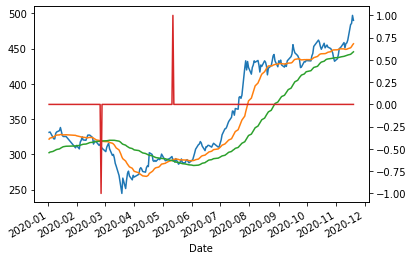

In [31]:
df.Close['2020'].plot()
sma1['2020'].plot()
sma2['2020'].plot()
signal['2020'].astype(int).plot(secondary_y=True)

In [35]:
sma1

2000-01-04        NaN
2000-01-05        NaN
2000-01-06        NaN
2000-01-07        NaN
2000-01-10        NaN
               ...   
2020-11-13    449.750
2020-11-16    451.075
2020-11-17    452.800
2020-11-18    455.000
2020-11-19    456.750
Length: 5145, dtype: float64

In [32]:
from backtesting import Backtest, Strategy

class Strategy(Strategy):
    
    n1 = 20
    n2 = 60
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1)
        sma2 = talib.SMA(close, timeperiod=self.n2)

        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot sma
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()

bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()

/Users/panyuehsheng/opt/anaconda3/envs/quant/lib/python3.8/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [33]:
result2 = bt.optimize(n1=range(5, 200, 10),
                      n2=range(5, 200, 10))
result2._strategy

<ipython-input-33-dea20e7a91a8>:1: UserWarning: Searching for best of 400 configurations.
  result2 = bt.optimize(n1=range(5, 200, 10),
/Users/panyuehsheng/opt/anaconda3/envs/quant/lib/python3.8/site-packages/backtesting/backtesting.py:1295: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


<Strategy Strategy(n1=165,n2=5)>

<AxesSubplot:>

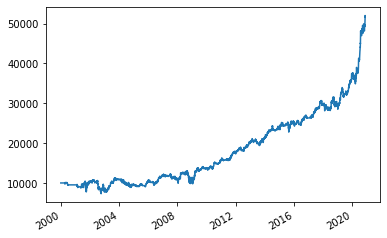

In [34]:
((result1._equity_curve.Equity + 
result2._equity_curve.Equity)/2).plot()